# Build a tree in Hyperiax

All the functions of Hyperiax are about trees. Thus, it is necessary to know how to actually build a tree in Hyperiax. This notebook will show you two main ways of building trees which should meet your needs in most of the cases.

A tree in Hyperiax is instantiated from the `HypTree` class defined in `hyperiax.tree.tree.py`, which is essentially a linked list by tree nodes as `TopologyNode`. When initializing the `HypTree`, Hyperiax will automatically do all the work including assigning data according to the desired topological order, precomputing a series of indices that is required for the execution engine to run on the tree, or other functions for tree visualizations.

The topology of the tree can be simply specified by some predefined functions in `hyperiax.tree.topology.py`, so that you don't need to arrange them by hands. Let's first see how we can create and plot trees with simple topologies.

**Content of the notebook**
* Build a tree with a defined topology

* Build a tree from Newick strings

In [1]:
import hyperiax
from hyperiax.tree.topology import symmetric_topology, asymmetric_topology, read_topology, write_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree

import jax
from jax import numpy as jnp

## Build a tree with a simple topology

### Choose the topology
The shape of the tree is determined by the topology. Take an asymmetric tree as an example, to build an asymmetric tree, with `h` depth and branchings, use `hyperiax.tree.topology.asymmetric_topology(depth)`. Note that before the branch lengths have been specified explicitly, the lengths are set to be uniform by default

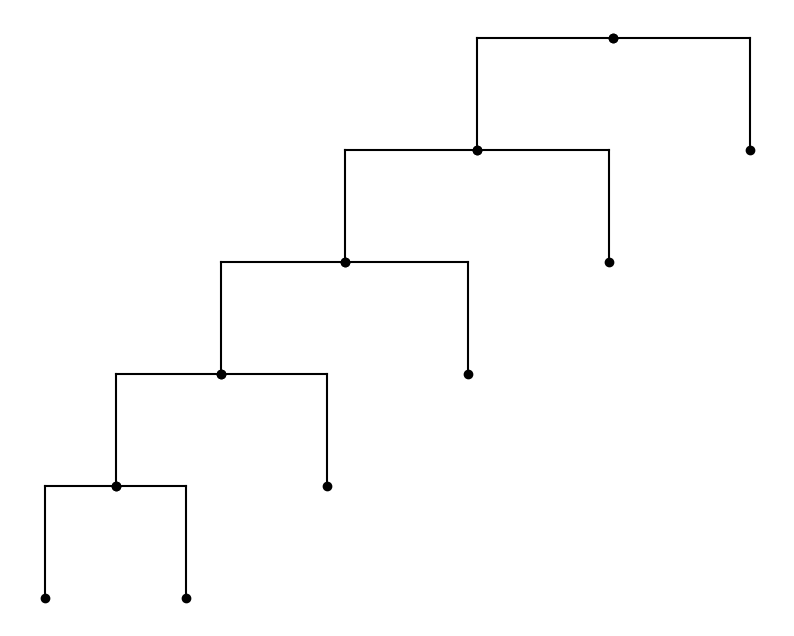

In [2]:
topology = asymmetric_topology(5)
tree = HypTree(topology)    
plot_tree(tree)

### Add node names
It is also possible to add names to the tree nodes to distinguish them. The names of nodes are recorded as the attributes of `TopologyNode`, therefore, can be accessed and changed through iterating over all the nodes. We use a symmetric tree to illustrate it.

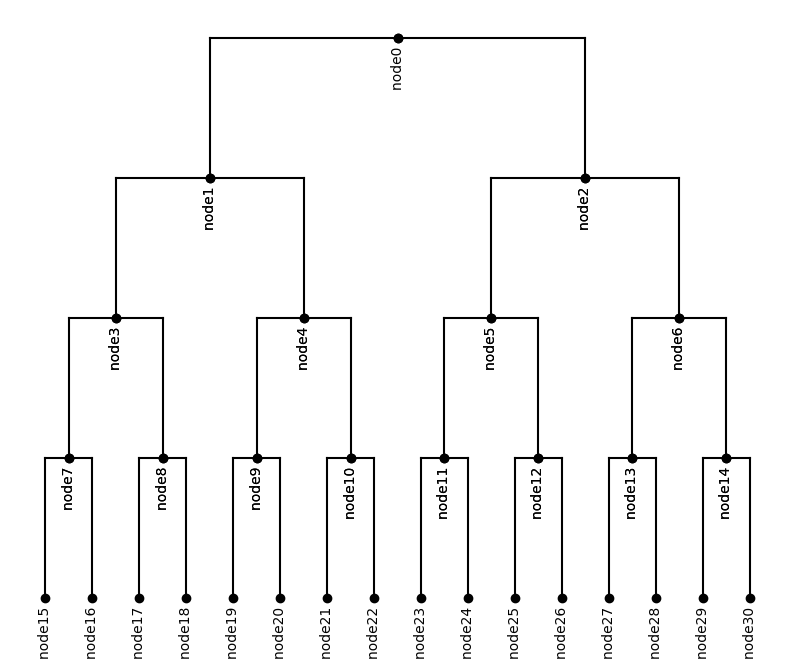

In [3]:
# build a symmetric tree of height 4 and degree 2
topology = symmetric_topology(height=4, degree=2)
tree = HypTree(topology)

# iterate over all the nodes in the tree and assign them a name
for i,node in enumerate(tree.iter_topology_bfs()):
    node.name = 'node' + str(i)
    # alternatively the below will yield the same result but save an enumeration
    # node.name = node.id 

plot_tree(tree,inc_names=True)

### Add edge lengths
Besides the node names, all the other properties including the edge lengths are stored in `TopologyNode`'s `data` attribute, which is a dictionary. It means you can assign and access these properties using their names as keys, and the value can be either constants read from files or expressions you want to compute, just like what you can do in a normal Python dict. Here, we use decaying exponential lengths based on the depth of nodes, such that nodes closer to the leaves have shorted edge lengths.

Since each `HypTree` will calculate the depth of each node, we can use them here. The depth of nodes is returned as a `jax.numpy.ndarray` that holds a single integer, and it is stored in the same order as the rest of the data in the tree. Thus, we can use it freely to do the computations or assign it to any data slot.

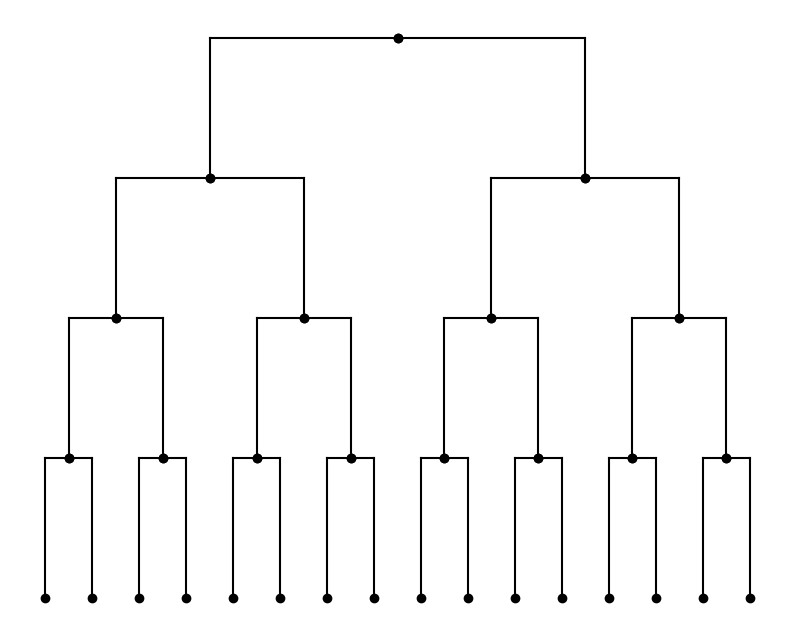

In [4]:
tree.add_property('edge_length', shape=(1,))
tree.data['edge_length'] = jnp.exp(-jnp.log(2)*tree.node_depths)
plot_tree(tree)

## Build a tree from a Newick string

For some trees with complex topologies that can not be included into `symmetric_topology` or `asymmetric_topology`, Hyperiax also provides the function that can directly create the tree by read the Newick string which is a way of representing graph-theoretical trees with edge lengths using parentheses and commas. The Newick format is commonly used in phylogenetics, which means it can be easily downloaded from a lot of phylogenetic databases and read by Hyperiax.

### A handwritten Newick tree
Let's start from a simple Newick string: `'(((A:1,B:1)H:0.5,(C:1,D:2)I:0.5)L:0.1,((E:1,F:1,G:1)J:0.5, K:0.5)M:0.1)N;'`. This string is totally enough to tell us all the information about this tree:
- The tree has height of 4
- The tree has 8 leaves named after A, B, C, D, E, F, G, K, and except node D and K, all the leaf nodes have same edge lengths of 1, and D has 2, K has 0.5
- The root of tree is called N
- The inner nodes are called H, I, J, L, M, individually

Let's create this tree with `hyperiax.tree.topology.tree_from_newick_recursive(newick_string)` and verify it.

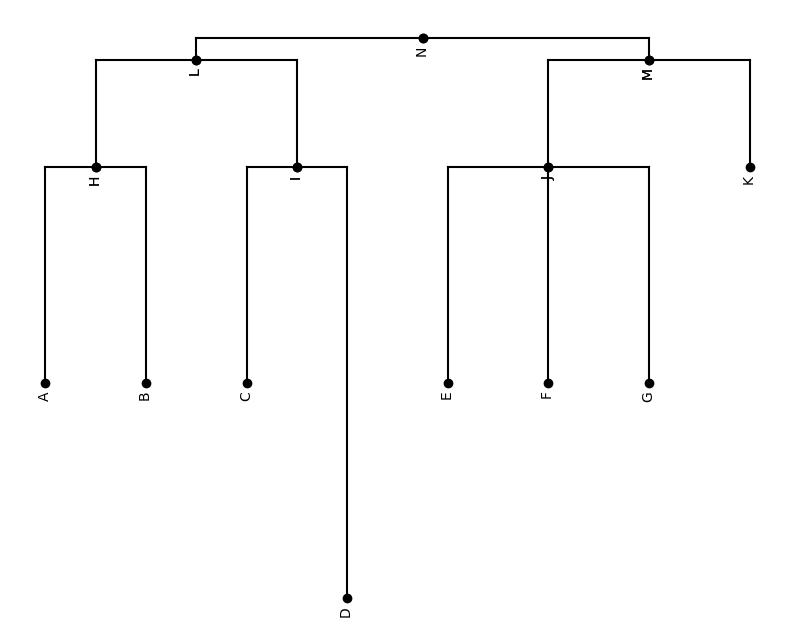

In [5]:
newick_string = '(((A:1,B:1)H:0.5,(C:1,D:2)I:0.5)L:0.1,((E:1,F:1,G:1)J:0.5, K:0.5)M:0.1)N;'
tree = read_topology(newick_string)
plot_tree(tree,inc_names=True)

This is exactly what we are expecting!

### A real phylogenetic tree
Now it's time to work on something real. Here is the Newick string of a smaller subset of the tree from Kawahara 2023 (DOI: 10.1038/s41559-023-02041-9), let's check if Hyperiax can make it.

'(Baronia_brevicornis:0.1711,((Iphiclides_podalirius:0.0847,((Graphium_evemon:0.0688,(Graphium_sarpedon:0.0547,Graphium_agamemnon:0.0519)QS1811:0.0137)QS1810:0.0610,Protographium_marcellus:0.0923)QS1808:0.0132)QS1807:0.0653,(((Hypermnestra_helios:0.0444,(Parnassius_orleans:0.0179,Parnassius_honrathi:0.0312)QS1821:0.0276)QS1820:0.0604,((Archon_apollinus:0.0358,Luehdorfia_puziloi:0.0365)QS1826:0.0339,(Sericinus_montela:0.0897,(Zerynthia_polyxena:0.0241,Allancastria_cerisyi:0.0235)QS1831:0.0304)QS1828:0.0309)QS1825:0.0197)QS1819:0.0257,(Teinopalpus_imperialis:0.0958,(((Battus_polydamas:0.0359,Battus_belus:0.0434)QS1835:0.0877,(Pharmacophagus_antenor:0.0796,(((Trogonoptera_brookiana:0.0370,(Troides_rhadamantus:0.0207,Ornithoptera_richmondia:0.0196)QS1840:0.0224)QS1839:0.0081,((Euryades_corethrus:0.0483,(Parides_agavus:0.0307,(Parides_photinus:0.0265,Parides_eurimedes:0.0282)QS1844:0.0108)QS1843:0.0125)QS1842:0.0056,Cressida_cressida:0.0735)QS1841:0.0134)QS1838:0.0094,((Byasa_alcinous:0.022

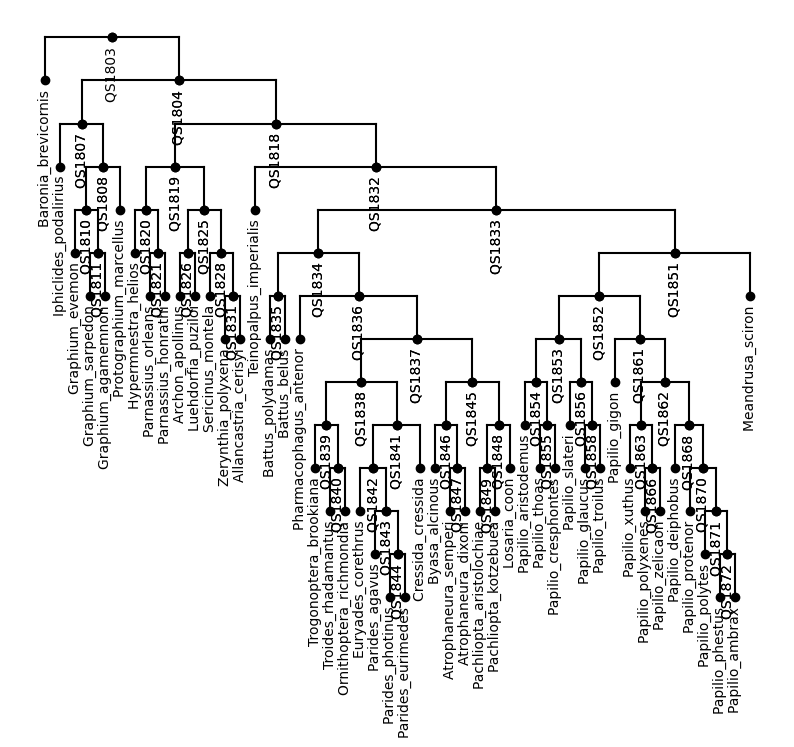

In [6]:
string_tree = "(Baronia_brevicornis:0.1711,((Iphiclides_podalirius:0.08472,((Graphium_evemon:0.06883,(Graphium_sarpedon:0.05466,Graphium_agamemnon:0.05188)QS1811:0.01369)QS1810:0.06096,Protographium_marcellus:0.09227)QS1808:0.01315)QS1807:0.0653,(((Hypermnestra_helios:0.04444,(Parnassius_orleans:0.01792,Parnassius_honrathi:0.03123)QS1821:0.0276)QS1820:0.06041,((Archon_apollinus:0.03581,Luehdorfia_puziloi:0.03646)QS1826:0.03388,(Sericinus_montela:0.08969,(Zerynthia_polyxena:0.02408,Allancastria_cerisyi:0.02345)QS1831:0.03039)QS1828:0.03093)QS1825:0.01972)QS1819:0.02572,(Teinopalpus_imperialis:0.09583,(((Battus_polydamas:0.0359,Battus_belus:0.04337)QS1835:0.08774,(Pharmacophagus_antenor:0.07956,(((Trogonoptera_brookiana:0.03698,(Troides_rhadamantus:0.02074,Ornithoptera_richmondia:0.01965)QS1840:0.02241)QS1839:0.00805,((Euryades_corethrus:0.04833,(Parides_agavus:0.03072,(Parides_photinus:0.02647,Parides_eurimedes:0.02819)QS1844:0.0108)QS1843:0.01245)QS1842:0.00564,Cressida_cressida:0.07354)QS1841:0.01338)QS1838:0.00944,((Byasa_alcinous:0.02248,(Atrophaneura_semperi:0.01043,Atrophaneura_dixoni:0.01171)QS1847:0.0129)QS1846:0.01879,((Pachliopta_aristolochiae:0.00348,Pachliopta_kotzebuea:0.00499)QS1849:0.0278,Losaria_coon:0.02297)QS1848:0.02356)QS1845:0.00935)QS1837:0.03434)QS1836:0.03812)QS1834:0.03412,((((Papilio_aristodemus:0.03095,(Papilio_thoas:0.00907,Papilio_cresphontes:0.00884)QS1855:0.02664)QS1854:0.03683,(Papilio_slateri:0.03379,(Papilio_glaucus:0.03012,Papilio_troilus:0.03835)QS1858:0.0096)QS1856:0.01012)QS1853:0.00628,(Papilio_gigon:0.06457,((Papilio_xuthus:0.03532,(Papilio_polyxenes:0.00579,Papilio_zelicaon:0.00541)QS1866:0.02599)QS1863:0.01789,(Papilio_deiphobus:0.02135,(Papilio_protenor:0.01221,(Papilio_polytes:0.01127,(Papilio_phestus:0.00377,Papilio_ambrax:0.00325)QS1872:0.00893)QS1871:0.00991)QS1870:0.007)QS1868:0.03981)QS1862:0.00747)QS1861:0.04588)QS1852:0.05955,Meandrusa_sciron:0.09096)QS1851:0.02719)QS1833:0.01405)QS1832:0.01719)QS1818:0.02038)QS1804:0.04527)QS1803:0;"
tree = read_topology(string_tree)
plot_tree(tree,inc_names=True)
write_topology(tree)

It works! 

## Summary
In this notebook, we know how to create a tree in Hyperiax, from either predefined topology or Newick strings. In the next one, we will see how to define some basic executions on the tree, and appreciate how fast and easy you can do this with Hyperiax.